### Setup

#### Import needful packages

In [0]:
import numpy as np
import numpy.random as rn
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import time

#### Observe Iris dataset

In [202]:
from sklearn.datasets import load_iris
    
# Load the Iris dataset
iris_dataset = load_iris()

print('The feature values for Obs 0 are: ', iris_dataset.data[0])
print('The feature names are: ', iris_dataset.feature_names)
print('The target value for Obs 0 is:', iris_dataset.target[0])
print('The target name for Obs 0 is:', iris_dataset.target_names[iris_dataset.target[0]])
print('The minimum values of the four features are:', np.min(iris_dataset.data, axis = 0))
print('The maximum values of the four features are:', np.max(iris_dataset.data, axis = 0))
print('The unique target values are:', np.unique(iris_dataset.target))

The feature values for Obs 0 are:  [5.1 3.5 1.4 0.2]
The feature names are:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
The target value for Obs 0 is: 0
The target name for Obs 0 is: setosa
The minimum values of the four features are: [4.3 2.  1.  0.1]
The maximum values of the four features are: [7.9 4.4 6.9 2.5]
The unique target values are: [0 1 2]


In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


NUM_CLASSES = 3

X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris_dataset.data, iris_dataset.target)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

#### Define the model

In [0]:
def build_model():
  model = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", use_bias=False, input_shape=X_train.shape[1:]),
    keras.layers.Dense(5, activation="relu", use_bias=False),
    keras.layers.Dense(NUM_CLASSES, activation="softmax",use_bias=False)
  ])
  opt = keras.optimizers.SGD(lr=.01)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

  return model

def evaluate_model_state(weights):
  model.set_weights(weights)
  train_evaluating = model.evaluate(X_train,y_train,batch_size=X_train.shape[0],verbose=0)
  test_evaluating = model.evaluate(X_test,y_test,batch_size=X_test.shape[0],verbose=0)
  print(f'Train loss: {train_evaluating[0]:.3f}, accuracy: {train_evaluating[1]:.3f}')
  print(f'Test loss: {test_evaluating[0]:.3f}, accuracy: {test_evaluating[1]:.3f}')

In [206]:
model = build_model()
model.summary()
initial_weights = model.get_weights()
evaluate_model_state(initial_weights)

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_187 (Dense)            (None, 5)                 25        
_________________________________________________________________
dense_188 (Dense)            (None, 3)                 15        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
38/38 [==============================] - 0s 41us/sample - loss: 1.1655 - acc: 0.2632
Train loss: 1.143, accuracy: 0.333
Test loss: 1.166, accuracy: 0.263


#### By default, Keras uses Glorot initialization with a uniform distribution



In [207]:
print(initial_weights)

[array([[-0.08256513,  0.45436323,  0.81061864, -0.2992763 ,  0.6332445 ],
       [-0.21427041, -0.776036  , -0.14705509, -0.5507741 , -0.25438994],
       [-0.00430137,  0.13732326, -0.38635516, -0.0692212 ,  0.43802118],
       [ 0.58402586, -0.28919035, -0.02547407, -0.49915358, -0.5042521 ]],
      dtype=float32), array([[-0.02057576,  0.20132071,  0.36510134, -0.31935096, -0.34521016],
       [ 0.70446455,  0.48994172,  0.57743657,  0.20924693, -0.14663118],
       [ 0.41803932, -0.6428888 , -0.5613319 ,  0.15174401,  0.4509014 ],
       [-0.2514503 ,  0.11144924, -0.4458567 , -0.28211153,  0.06424367],
       [ 0.05873102, -0.6525482 , -0.41218928,  0.6517674 ,  0.371657  ]],
      dtype=float32), array([[ 0.8522356 ,  0.03918016, -0.00314796],
       [-0.72490054,  0.48966175, -0.17812341],
       [-0.8168433 , -0.41320932,  0.22749275],
       [-0.1287561 ,  0.6172833 ,  0.55576605],
       [ 0.8263592 ,  0.51314443, -0.6807401 ]], dtype=float32)]


### Using simulated annealing

#### Train

In [0]:
def annealing(random_start,
            cost_function,
            random_neighbour,
            acceptance,
            temperature,
            debug=True):
  """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
  state = copy.deepcopy(initial_weights)
  cost = cost_function(state)
  step = 1
  T = 1
  costs, temperatures = [cost], [T]
  temperature_cooled_down = 0.1
  while T > temperature_cooled_down:
    new_state = random_neighbour(state)
    new_cost = cost_function(new_state)
    alpha = get_alpha(cost, new_cost, T)
    u = rn.random()
    if debug: print(f"Step #{step}:  T = {T:.2f}, cost = {cost:.2f}, new_cost = {new_cost:.2f}, alpha = {alpha:.2f}, u = {u:.2f}")
    if alpha >= u:
      state, cost = new_state, new_cost
      costs.append(cost)
      temperatures.append(T)
    step += 1
    T = temperature(T)
  return step, state, costs, temperatures

def cost_function(weights):
  """ Function to minimize."""
  model.set_weights(weights)
  return model.evaluate(X_train,y_train,batch_size=X_train.shape[0],verbose=0)[0]

def clip(weight):
  """ Force weight to be in the appropriate interval for neural network weights."""
  interval = (-1, 1)
  a, b = interval
  return max(min(weight, b), a)

def random_neighbour(weights):
  """Generate new weights using the normal distribution with mean equal to previous weights"""
  sigma = 0.5
  for layer_idx in range(0,len(weights)):
    for neuron_idx in range(0,len(weights[layer_idx])):     
      for weight_idx in range(0,len(weights[layer_idx][neuron_idx])):
        random_weight=rn.normal(weights[layer_idx][neuron_idx][weight_idx],sigma)
        weights[layer_idx][neuron_idx][weight_idx]=clip(random_weight)
  return weights

def get_alpha(cost, new_cost, temperature):
  """Calculate acceptance ratio"""
  return np.exp(- (new_cost - cost) / temperature)

def temperature(old_temperature):
  """ Temperature dicreasing as the process goes on."""
  a = 0.99
  return old_temperature*a

In [223]:
start_time = time.time()
num_steps, final_weights, costs, temperatures = annealing(random_start,
                                                          cost_function,
                                                          random_neighbour,
                                                          acceptance_probability,
                                                          temperature,
                                                          debug=True)
finish_time = time.time()

Step #1:  T = 1.00, cost = 1.14, new_cost = 1.83, alpha = 0.50, u = 0.85
Step #2:  T = 0.99, cost = 1.14, new_cost = 1.66, alpha = 0.60, u = 0.13
Step #3:  T = 0.98, cost = 1.66, new_cost = 1.95, alpha = 0.74, u = 0.65
Step #4:  T = 0.97, cost = 1.95, new_cost = 3.42, alpha = 0.22, u = 0.92
Step #5:  T = 0.96, cost = 1.95, new_cost = 2.06, alpha = 0.89, u = 0.39
Step #6:  T = 0.95, cost = 2.06, new_cost = 2.55, alpha = 0.60, u = 0.55
Step #7:  T = 0.94, cost = 2.55, new_cost = 1.97, alpha = 1.85, u = 0.03
Step #8:  T = 0.93, cost = 1.97, new_cost = 1.16, alpha = 2.38, u = 0.17
Step #9:  T = 0.92, cost = 1.16, new_cost = 3.34, alpha = 0.09, u = 0.62
Step #10:  T = 0.91, cost = 1.16, new_cost = 5.19, alpha = 0.01, u = 0.33
Step #11:  T = 0.90, cost = 1.16, new_cost = 4.41, alpha = 0.03, u = 0.37
Step #12:  T = 0.90, cost = 1.16, new_cost = 4.42, alpha = 0.03, u = 0.92
Step #13:  T = 0.89, cost = 1.16, new_cost = 2.04, alpha = 0.37, u = 0.97
Step #14:  T = 0.88, cost = 1.16, new_cost = 2.

#### Evaluate

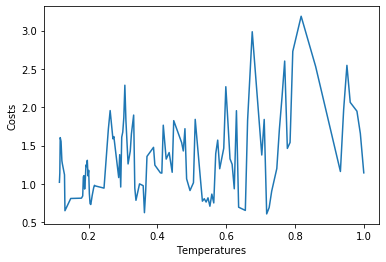

================== Initial model ==================
Train loss: 1.143, accuracy: 0.333
Test loss: 1.166, accuracy: 0.263
================== Final model ==================
Train loss: 1.119, accuracy: 0.321
Test loss: 1.001, accuracy: 0.526
Duration: 1.006 s


In [224]:
def plot(costs, temperatures):
  plt.plot(temperatures, costs)
  plt.xlabel('Temperatures')
  plt.ylabel('Costs')
  plt.show()

plot(costs, temperatures)
print('================== Initial model ==================')
evaluate_model_state(initial_weights)
print('================== Final model ==================')
evaluate_model_state(final_weights)
print('=================================================')
print(f'Duration: {(finish_time - start_time):.3f} s')

### Using backpropagation

#### Train

In [225]:
model.set_weights(initial_weights)
start_time = time.time()
model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=num_steps-1, shuffle=False)
finish_time = time.time()
final_weights = model.get_weights()

Train on 84 samples
Epoch 1/230
84/84 [==============================] - 0s 30us/sample - loss: 1.1432 - acc: 0.3333
Epoch 2/230
84/84 [==============================] - 0s 38us/sample - loss: 1.1391 - acc: 0.3452
Epoch 3/230
84/84 [==============================] - 0s 29us/sample - loss: 1.1353 - acc: 0.3571
Epoch 4/230
84/84 [==============================] - 0s 20us/sample - loss: 1.1315 - acc: 0.3571
Epoch 5/230
84/84 [==============================] - 0s 31us/sample - loss: 1.1277 - acc: 0.3690
Epoch 6/230
84/84 [==============================] - 0s 19us/sample - loss: 1.1241 - acc: 0.3690
Epoch 7/230
84/84 [==============================] - 0s 17us/sample - loss: 1.1206 - acc: 0.3810
Epoch 8/230
84/84 [==============================] - 0s 31us/sample - loss: 1.1172 - acc: 0.3810
Epoch 9/230
84/84 [==============================] - 0s 18us/sample - loss: 1.1140 - acc: 0.3810
Epoch 10/230
84/84 [==============================] - 0s 19us/sample - loss: 1.1107 - acc: 0.3810
Epoch 11/

#### Evaluate

In [226]:
print('================== Initial model ==================')
evaluate_model_state(initial_weights)
print('================== Final model ==================')
evaluate_model_state(final_weights)
print('=================================================')
print(f'Duration: {(finish_time - start_time):.3f} s')

================== Initial model ==================
Train loss: 1.143, accuracy: 0.333
Test loss: 1.166, accuracy: 0.263
================== Final model ==================
Train loss: 0.652, accuracy: 0.845
Test loss: 0.794, accuracy: 0.579
Duration: 1.608 s
